In [309]:
import sys
import numpy as np
import scipy.optimize as opt
import pandas as pd
from matplotlib import pyplot as plt, animation
from matplotlib.lines import Line2D
import proplot as plot
import seaborn as sns
from tqdm import tqdm

sys.path.append('/Users/46h/Research/code/accphys')
from tools import envelope_analysis as ea
from tools import plotting as myplt
from tools import animation as myanim
from tools import utils
from tools.utils import show

In [2]:
plot.rc['figure.facecolor'] = 'white'
plot.rc['cycle'] = 'default'
plot.rc['savefig.dpi'] = 'figure'
plot.rc['animation.html'] = 'jshtml'

# 4D Measurement in RTBT
> This notebook reconstructs the beam covariance matrix at the entrance of the Ring to Target Beam Transport (RTBT) section of the Spallation Neutron Source (SNS).

<img src="_fig/rtbt.png" width=800>

## Method summary

The goal is to reconstruct the transverse beam covariance matrix at position $s = s_0$:

$$
\Sigma_{0} = \begin{bmatrix}
    \langle{x^2}\rangle & \langle{xx'}\rangle & \langle{xy}\rangle & \langle{xy'}\rangle \\
    \langle{xx'}\rangle & \langle{{x'}^2}\rangle & \langle{yx'}\rangle & \langle{x'y'}\rangle \\
    \langle{xy}\rangle & \langle{yx'}\rangle & \langle{y^2}\rangle & \langle{yy'}\rangle \\
    \langle{xy'}\rangle & \langle{x'y'}\rangle & \langle{yy'}\rangle & \langle{{y'}^2}\rangle
\end{bmatrix}.
$$

To do this, a set of $n$ wire-scanners can be placed at positions $\{s_i\} > s_0$ with $i = 1, ..., n$. A single measurement from wire-scanner $i$ will produce the real-space moments of the beam at $s_i$: $\langle{x^2}\rangle_{i}$, $\langle{y^2}\rangle_{i}$, and $\langle{xy}\rangle_{i}$. Without space charge, the transfer matrix $M_{s_0 \rightarrow s_i} = M_i$ is known. The moments at $s_0$ are then directly related to those at $s_i$ by

$$\Sigma_i = M_i \Sigma_{0} {M_i}^T.$$ This gives <br>

$$
\begin{align}
    \langle{x^2}\rangle_i &= 
        m_{11}^2\langle{x^2}\rangle_{0} 
      + m_{12}^2\langle{x'^2}\rangle_{0} 
      + 2m_{11}m_{22}\langle{xx'}\rangle_{0} ,\\
    \langle{y^2}\rangle_i &= 
        m_{33}^2\langle{y^2}\rangle_{0} 
      + m_{34}^2\langle{y'^2}\rangle_{0} 
      + 2m_{33}m_{34}\langle{yy'}\rangle_{0} ,\\
    \langle{xy}\rangle_i &= 
        m_{11}m_{33}\langle{xy}\rangle_{0} 
      + m_{12}m_{33}\langle{yx'}\rangle_{0} 
      + m_{11}m_{34}\langle{xy'}\rangle_{0} 
      + m_{12}m_{34}\langle{x'y'}\rangle_{0} ,
\end{align}
$$

where $m_{lm}$ are the elements of the transfer matrix. Taking 3 measurements with different sets of optics between $s_0$ and $s_i$ (and therefore different transfer matrices) gives the 10 equations necessary to solve for $\Sigma_0$; however, real measurements will be noisy, so it is better to take more measurements if possible. Given $N$ measurements, we can form a $3N \times 1$ observation array $b$ from the measured moments and a $3N \times 10$ coefficient array $A$ from the transfer matrix such that

$$\begin{align} \mathbf{A \sigma}_0 = \mathbf{b},\end{align}$$ 

where $\mathbf{\sigma}_0$ is a $10 \times 1$ vector of the moments at $s_0$. There are 5 wire-scanners in the RTBT which operate simultaneously, and it is probably feasible to take around 25 measurements. We then choose $\mathbf{\sigma}_0$ such that $|\mathbf{A\sigma}_0 - \mathbf{b}|^2$ is minimized. 

## RTBT lattice functions 

In [3]:
twiss = pd.read_csv('_output/data/twiss.dat')

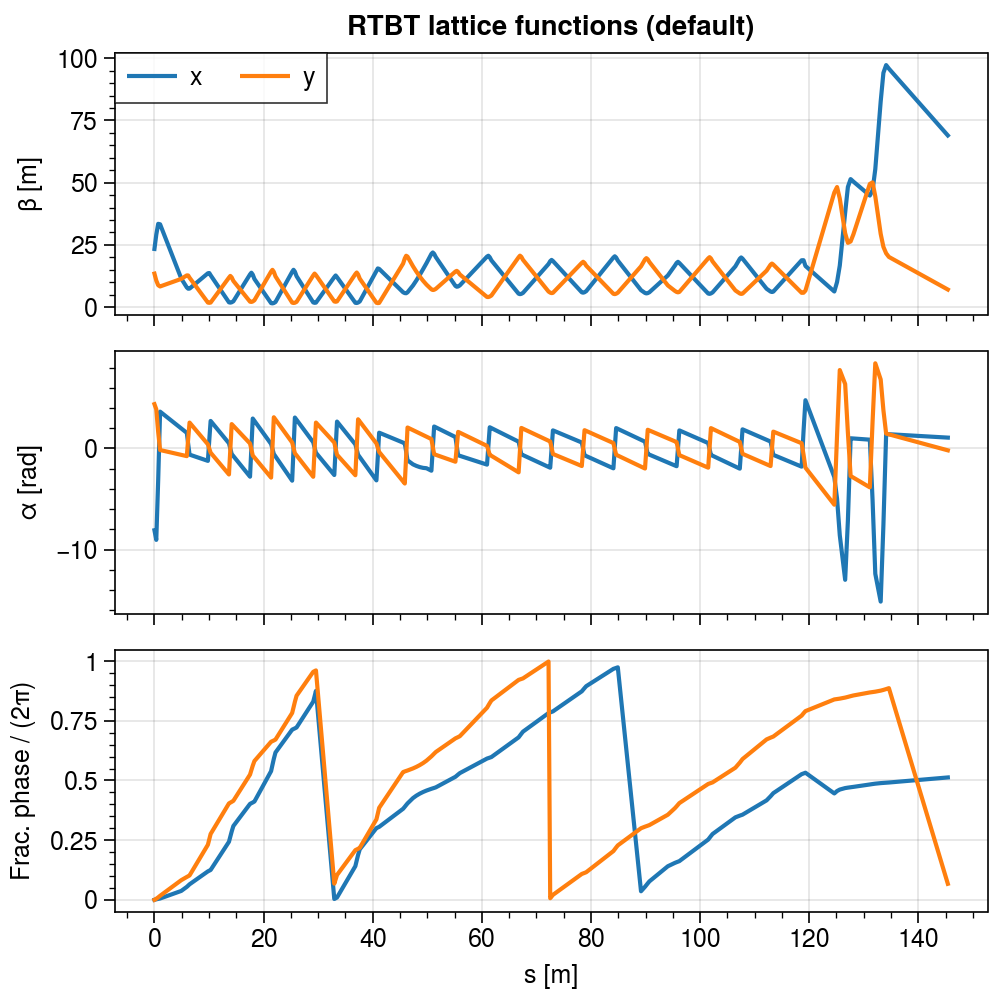

In [4]:
fig, axes = plot.subplots(nrows=3, figsize=(5, 5), spany=False)
ax1, ax2, ax3 = axes
twiss[['s','bx','by']].plot('s', ax=ax1, legend=False)
twiss[['s','ax','ay']].plot('s', ax=ax2, legend=False)
twiss[['s','nux','nuy']].plot('s', ax=ax3, legend=False);
axes.format(xlabel='s [m]', toplabels='RTBT lattice functions (default)')
for ax, ylabel in zip(axes, [r'$\beta$ [m]', r'$\alpha$ [rad]', 'Frac. phase / ($2\pi$)']):
    ax.format(ylabel=ylabel);
ax1.legend(labels=['x', 'y']);

## Phase scan 

In [5]:
ws_names = ['ws02', 'ws20', 'ws21', 'ws23', 'ws24']
ws_names_to_use_in_scan = ws_names[:]

In [6]:
def load(file, ws_name):
    path = '_output/data/{}_{}.npy'.format(file, ws_name)
    return np.load(path)

moments_dict, transfer_mats_dict, phase_advances_dict, env_params_dict = {}, {}, {}, {}
for ws_name in ws_names:
    moments_dict[ws_name] = 1e6 * load('moments', ws_name)
    transfer_mats_dict[ws_name] = load('transfer_mats', ws_name)
    phase_advances_dict[ws_name] = load('phase_advances', ws_name)
    env_params_dict[ws_name] = 1e3 * load('env_params', ws_name)
    
moments = np.vstack([moments_dict[ws_name] for ws_name in ws_names_to_use_in_scan])
transfer_mats = np.vstack([transfer_mats_dict[ws_name] for ws_name in ws_names_to_use_in_scan])
phase_advances = np.vstack([phase_advances_dict[ws_name] for ws_name in ws_names_to_use_in_scan])
env_params = np.vstack([env_params_dict[ws_name] for ws_name in ws_names_to_use_in_scan])
Sigma0 = 1e6 * np.load('_output/data/Sigma0.npy')

Observe beam at wire-scanner.

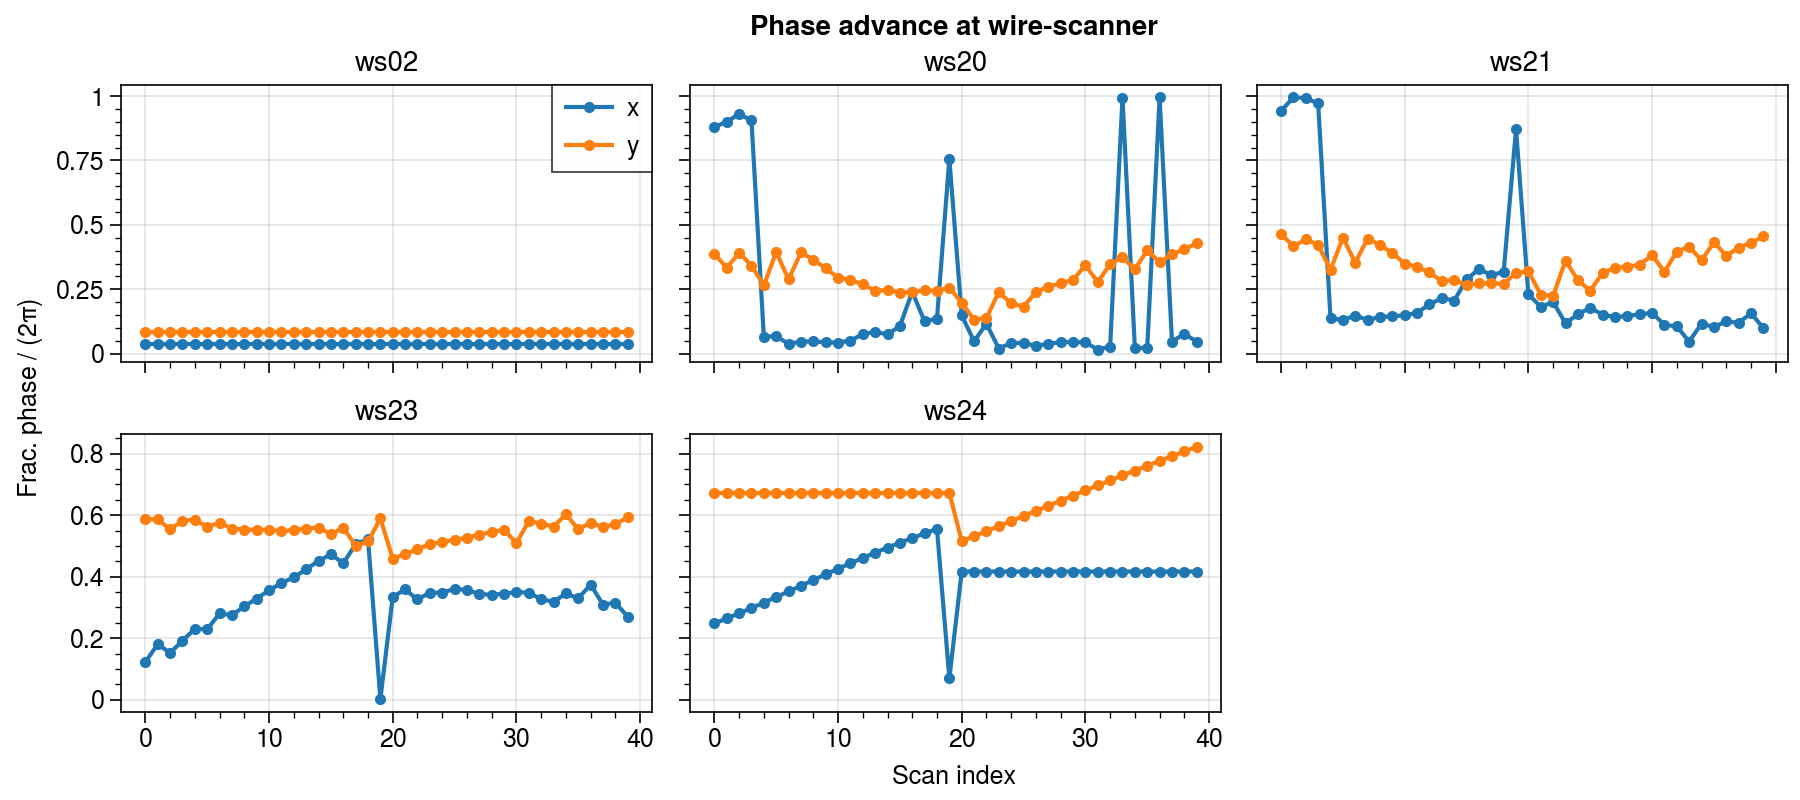

In [7]:
fig, axes = plot.subplots(nrows=2, ncols=3, figsize=(9, 4))
for ax, ws_name in zip(axes, ws_names):
    ax.plot(phase_advances_dict[ws_name] % 1, marker='.');
    ax.set_title(ws_name, color='grey' if ws_name not in ws_names_to_use_in_scan else 'k')
axes.format(ylabel='Frac. phase / ($2\pi$)', xlabel='Scan index', suptitle='Phase advance at wire-scanner')
axes[-1].axis('off')
axes[0].legend(labels=['x', 'y'], ncols=1);

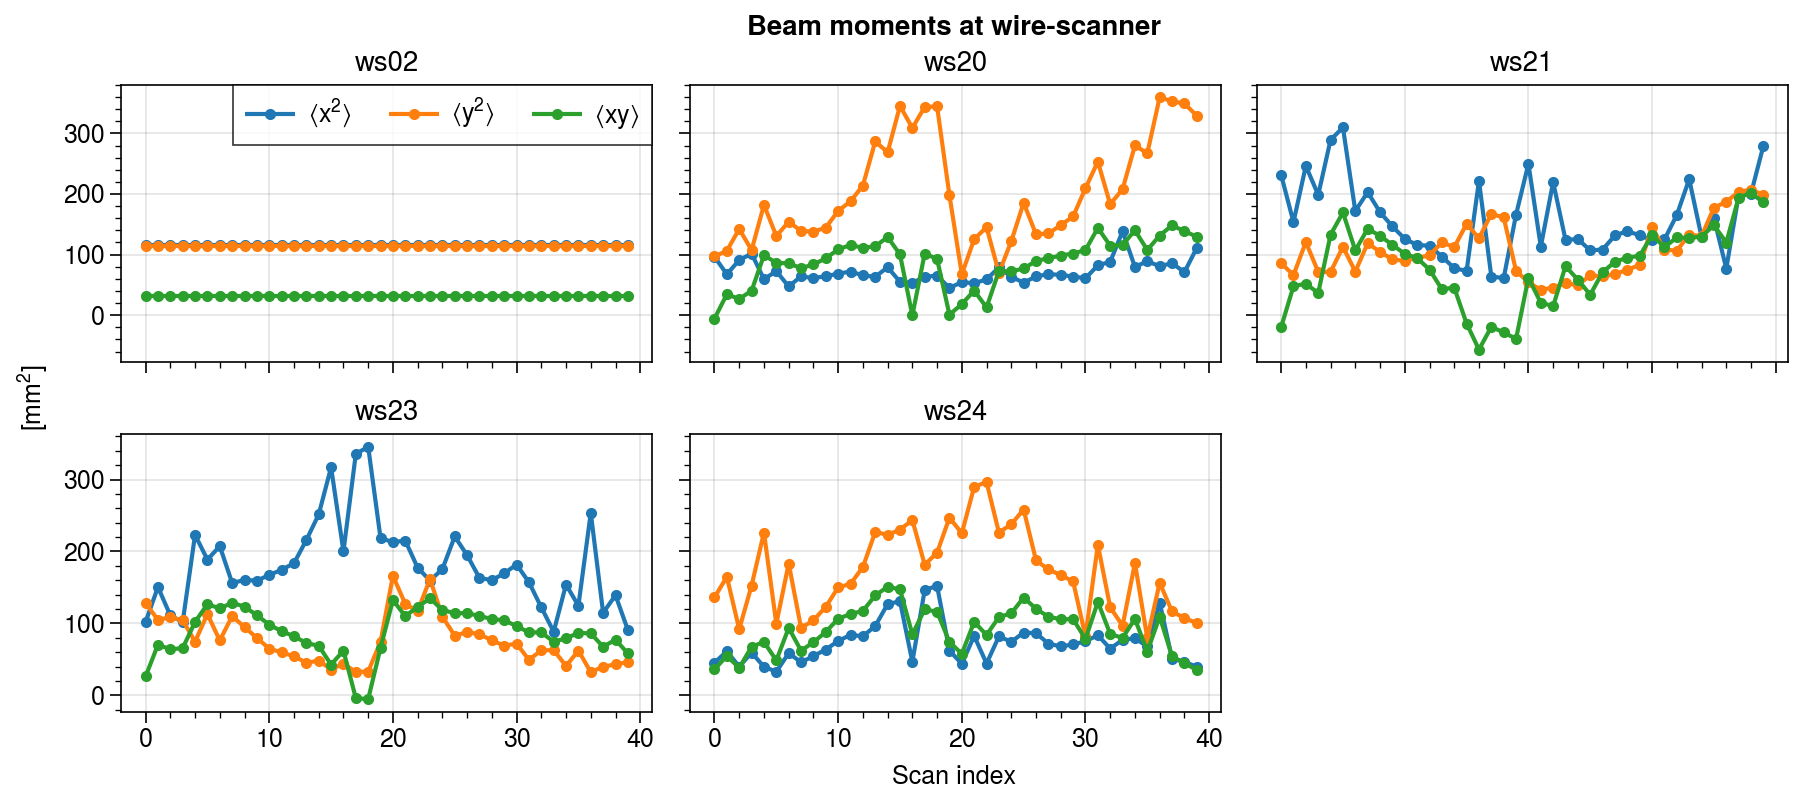

In [8]:
fig, axes = plot.subplots(nrows=2, ncols=3, figsize=(9, 4))
for ax, ws_name in zip(axes, ws_names):
    ax.plot(moments_dict[ws_name][:, 0], marker='.')
    ax.plot(moments_dict[ws_name][:, 1], marker='.')
    ax.plot(moments_dict[ws_name][:, 2], marker='.')
    ax.set_title(ws_name, color='grey' if ws_name not in ws_names_to_use_in_scan else 'k')
axes.format(ylabel='[mm$^2$]', xlabel='Scan index', suptitle='Beam moments at wire-scanner')
axes[0].legend(labels=[r'$\langle{x^2}\rangle$', r'$\langle{y^2}\rangle$', r'$\langle{xy}\rangle$']);
axes[-1].axis('off');

In [9]:
coords_list = [ea.get_ellipse_coords(env_params_dict[ws_name]) for ws_name in ws_names]

pad = 0.25
limits_list = np.array([(1 + pad) * myplt.get_u_up_max_global(coords) for coords in coords_list])
umax, _ = np.max(limits_list, axis=0)

fig, ax_list = plt.subplots(ncols=6, figsize=(13, 1.75), sharex=True, sharey=True)
axes, text_ax = ax_list[:-1], ax_list[-1]
text_ax.grid(False)
myplt.despine([text_ax], 'all')
myplt.despine(axes)
axes[0].set_xlim(-umax, umax);  axes[0].set_ylim(-umax, umax)
axes[0].set_yticks(axes[0].get_xticks())
axes[0].set_xlabel('x [mm]');  axes[0].set_ylabel('y [mm]')
for ax, ws_name in zip(axes, ws_names):
    ax.set_title(ws_name, color='grey' if ws_name not in ws_names_to_use_in_scan else 'k')
plt.close()

def update(t):
    for ax, coords in zip(axes, coords_list):
        for patch in ax.patches:
            patch.remove()
        ax.fill(coords[t, :, 0], coords[t, :, 2], fc='lightsteelblue', ec='k', zorder=10)
    for text in text_ax.texts:
        text.remove()
    text_ax.annotate('Scan index = {}'.format(t), xy=(0.25, 0.5), xycoords='axes fraction', horizontalalignment='center')

nframes = coords_list[0].shape[0]
animation.FuncAnimation(fig, update, frames=nframes, interval=1000/1)

## Reconstruction

In [10]:
def to_mat(sigma):
    """Return covariance matrix from 10 element moment vector."""
    s11, s22, s12, s33, s44, s34, s13, s23, s14, s24 = sigma
    return np.array([[s11, s12, s13, s14], 
                     [s12, s22, s23, s24], 
                     [s13, s23, s33, s34], 
                     [s14, s24, s34, s44]])

def to_vec(Sigma):
    """Return 10 element moment vector from covariance matrix."""
    s11, s12, s13, s14 = Sigma[0, :]
    s22, s23, s24 = Sigma[1, 1:]
    s33, s34 = Sigma[2, 2:]
    s44 = Sigma[3, 3]
    return np.array([s11, s22, s12, s33, s44, s34, s13, s23, s14, s24])

We cannot just use linear least-squares to solver the overdetermined system of equations. If there is some error in the measurements, linear least squares may converge to a solution which is a) wrong and b) unphysical (correlation coefficients greater than 1). In fact, the block diagonals of $\Sigma$ are relatively insensitive to errors using this method, but the cross-plane moments are highly sensitive, often shooting off to some very large number. 

Thus, b) must be added as a nonlinear constraint. It works using `scipy.minimize(..., method='trust-constr')` and is pretty tolerant to measurement errors. There is just one thing I'm not sure of... the method requires an initial guess, and will fail if this guess is sufficiently far from the solution. We won't have access to the actual solution in reality, so will have to think about this.

In [56]:
def solve(A, b, guess=None, verbose=1, xtol=1e-8, maxiter=1000):
    """Reconstruct covariance matrix from measured data.
    
    Solves the problem A.sigma = b, where sigma is the vector
    of 10 beam moments at the reconstruction point and A and 
    b are defined below.
    
    Parameters
    ----------
    A : ndarray, shape (3n, 10)
        Coefficient array determined by transfer matrix elements.
    b : ndarray, shape (3n,)
        Observation array determined by beam moments at measurement location.
    guess : ndarray, shape (10,) or None
        Initial guess.

    Returns
    -------
    ndarray, shape (4, 4)
        Covariance matrix at reconstruction point.
    """
    def cost(sigma, A, b):
        return 0.5 * np.sum((np.matmul(A, sigma) - b)**2)

    # squared moments can't be negative
    lb = 10 * [-np.inf]
    lb[0] = lb[1] = lb[3] = lb[4] = 0.0 
    bounds = opt.Bounds(lb, np.inf, keep_feasible=False)
    
    # correlation coefficients must be in range [-1, 1]
    def corr_coeffs(sigma):
        return to_vec(utils.cov2corr(to_mat(sigma)))
    constr = opt.NonlinearConstraint(corr_coeffs, -1, 1) 
    
    if guess is None:
        guess = to_vec(np.diag([100, 10, 100, 10]))
    result = opt.minimize(
        cost, guess, args=(A, b), bounds=bounds, constraints=constr, method='trust-constr', 
        options={'verbose':verbose, 'xtol':xtol, 'maxiter':maxiter}
    )
    return to_mat(result.x)

Form coefficent and observation arrays.  

In [221]:
A, b = [], []
for M, (x2, y2, xy) in zip(transfer_mats, moments):
    A.append([M[0, 0]**2, M[0, 1]**2, 2*M[0, 0]*M[0, 1], 0, 0, 0, 0, 0, 0, 0])
    A.append([0, 0, 0, M[2, 2]**2, M[2, 3]**2, 2*M[2, 2]*M[2, 3], 0, 0, 0, 0])
    A.append([0, 0, 0, 0, 0, 0, M[0, 0]*M[2, 2],  M[0, 1]*M[2, 2],  M[0, 0]*M[2, 3],  M[0, 1]*M[2, 3]])
    b.append(x2)
    b.append(y2)
    b.append(xy)
A, b = np.array(A), np.array(b)

In [255]:
guess = to_vec(Sigma0 + 20*np.random.random((4, 4))) 
Sigma = solve(A, b, guess, verbose=1)
print()
show(Sigma, 'Sigma')
print()
show(Sigma0, 'Sigma0')
print()
show(Sigma - Sigma0, 'Sigma - Sigma0')

/Users/46h/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +


`xtol` termination condition is satisfied.
Number of iterations: 198, function evaluations: 2211, CG iterations: 732, optimality: 3.33e+03, constraint violation: 2.22e-16, execution time: 0.67 s.

Sigma =
⎡251.869  87.059   6.769   10.887 ⎤
⎢                                 ⎥
⎢87.059   30.51    -5.38    6.289 ⎥
⎢                                 ⎥
⎢ 6.769   -5.38   136.382  -44.528⎥
⎢                                 ⎥
⎣10.887   6.289   -44.528  15.285 ⎦

Sigma0 =
⎡234.713  81.197  -0.654   13.448 ⎤
⎢                                 ⎥
⎢81.197   28.522  -7.902    7.151 ⎥
⎢                                 ⎥
⎢-0.654   -7.902  136.114  -44.346⎥
⎢                                 ⎥
⎣13.448   7.151   -44.346  15.194 ⎦

Sigma - Sigma0 =
⎡17.156  5.862   7.423   -2.561⎤
⎢                              ⎥
⎢5.862   1.988   2.522   -0.862⎥
⎢                              ⎥
⎢7.423   2.522   0.268   -0.182⎥
⎢                              ⎥
⎣-2.561  -0.862  -0.182  0.091 ⎦


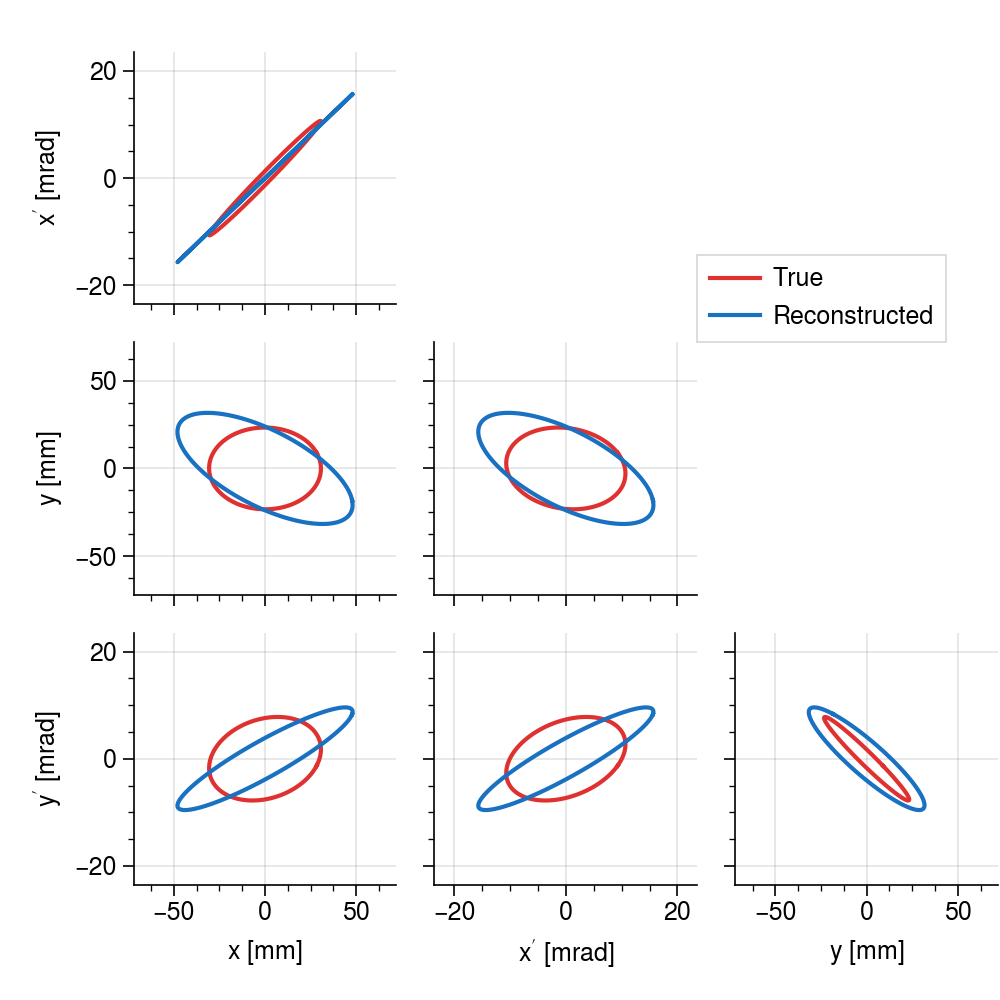

In [345]:
def fit_env(Sigma):
    env = ea.Envelope()
    env.fit_cov(Sigma)
    return env.params

myplt.corner_env([fit_env(S) for S in (Sigma0, Sigma)], cmap=plot.Colormap(('red8', 'blue8')), 
                 legend_kws=dict(labels=('True','Reconstructed'), loc=(1, 1)));

## Error analysis 

### Initial guess

The solver will not converge to the correct answer if the guess is sufficiently far away from the correct answer. Let's add some random error to the initial guess (while making sure the resulting matrix is still a covariance matrix) and see how this affects the reconstruction error. The matrix below will be scaled by `factor` and then added to $\Sigma_0$.

In [312]:
Z = np.random.random(size=(4, 4))
np.matmul(Z.T, Z)

array([[0.90165682, 1.44722279, 1.02195714, 0.49336088],
       [1.44722279, 2.52403965, 1.67619902, 0.98863419],
       [1.02195714, 1.67619902, 1.28322308, 0.76126242],
       [0.49336088, 0.98863419, 0.76126242, 0.78450292]])

In [313]:
def perturb(Sigma0, factor=1.0):
    Z = np.random.random(size=(4, 4))
    return Sigma0 + factor * np.matmul(Z.T, Z)

eps_ideal = ea.intrinsic_emittances(Sigma0)
factors = np.linspace(0, 100, 11)
emittances = np.zeros((len(factors), 2)) # eps1, eps2
Sigmas = []
for i, factor in enumerate(tqdm(factors)):
    guess = to_vec(perturb(Sigma0, factor))
    Sigma = solve(A, b, guess, verbose=0)
    emittances[i, :] = ea.intrinsic_emittances(Sigma)
    Sigmas.append(Sigma)

  9%|▉         | 1/11 [00:03<00:39,  3.93s/it]/Users/46h/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
100%|██████████| 11/11 [00:15<00:00,  1.43s/it]


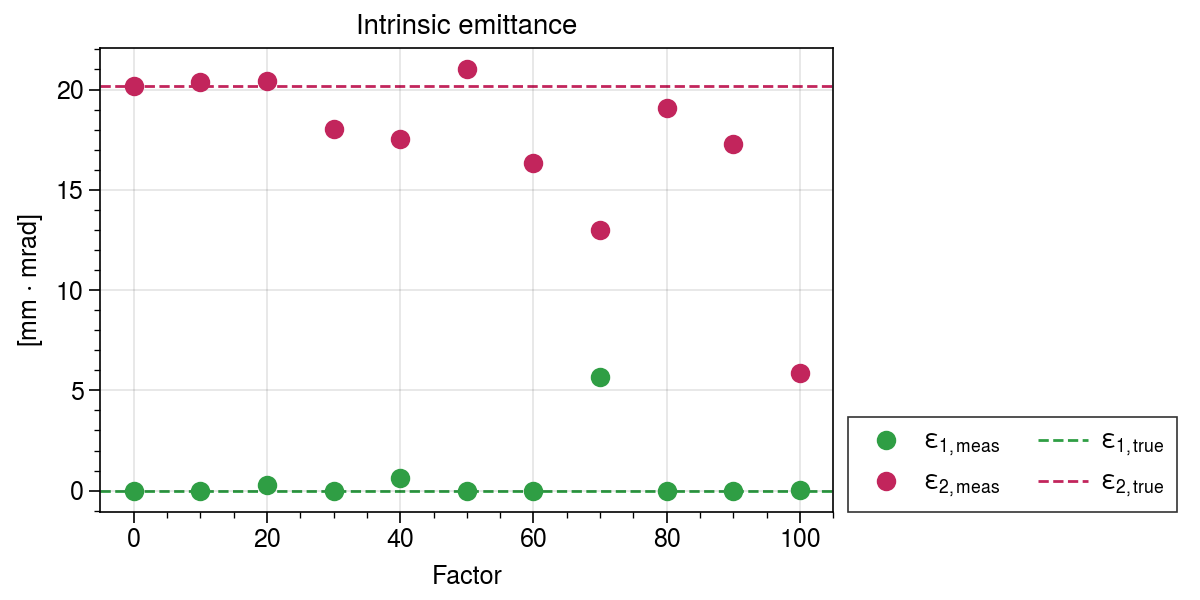

In [346]:
fig, ax = plot.subplots(figsize=(6, 3))
for i, color in enumerate(['green8', 'pink8']):
    ax.plot(factors, emittances[:, i], marker='o', lw=0, color=color)
    ax.axhline(eps_ideal[i], ls='--', lw=1, zorder=0, color=color)
ax.format(grid=True, xlabel='Factor', ylabel='[mm $\cdot$ mrad]', title='Intrinsic emittance')
ax.legend(labels=[r'$\varepsilon_{1, meas}$', r'$\varepsilon_{1, true}$', r'$\varepsilon_{2, meas}$', r'$\varepsilon_{2, true}$'], 
          ncols=2, loc=(1.02, 0));

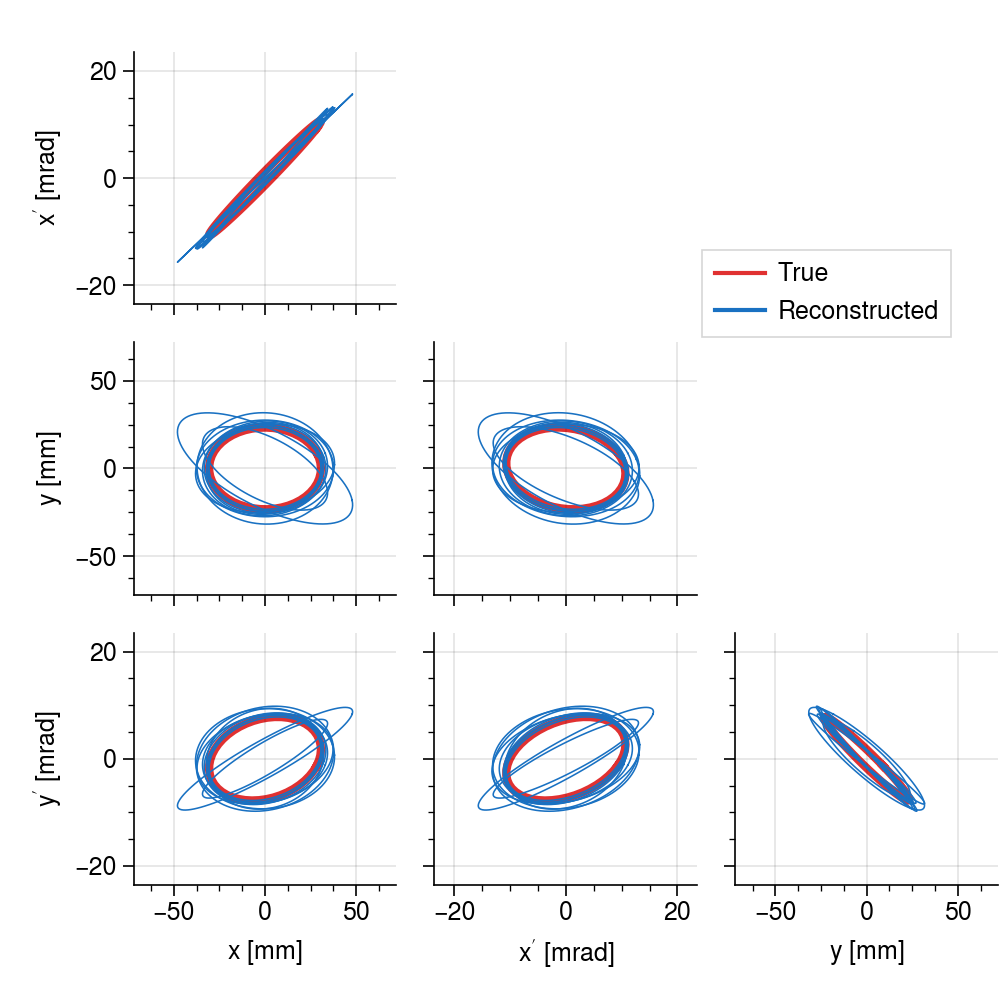

In [350]:
env_params = [fit_env(S) for S in Sigmas]
axes = myplt.corner_env(env_params, color='blue8', lw=0.57);

X = ea.get_coords(fit_env(Sigma0))
for i in range(3):
    for j in range(i + 1):
        axes[i, j].plot(X[:, j], X[:, i+1], color='red8', zorder=0, lw=3)
axes[1, 1].legend([Line2D([0], [0], color='red8'), Line2D([0], [0], color='blue8')], ['True', 'Reconstructed'], loc=(1.02, 1.02))

It seems that we will be okay as long as our guess is somewhat near the true value. Note that the envelope cannot be fit perfectly to the covariance matrix when the intrinsic emittances is non-zero.

### Measurement errors

Here we add an error to each measurement sampled from a Gaussian distribution.

In [352]:
def blur(b, variance=1.0, mean=0.0):
    return b + np.random.normal(loc=mean, scale=variance, size=b.shape)

guess = to_vec(Sigma0)
variances = np.linspace(0, 49, 21) # [mm^2]
emittances = np.zeros((len(variances), 2)) # eps1, eps2
Sigmas = []

for i, variance in enumerate(tqdm(variances)):
    Sigma = solve(A, blur(b, amplitude, variance), guess, verbose=0)
    emittances[i, :] = ea.intrinsic_emittances(Sigma)
    Sigmas.append(Sigma0)

100%|██████████| 21/21 [00:58<00:00,  2.80s/it]


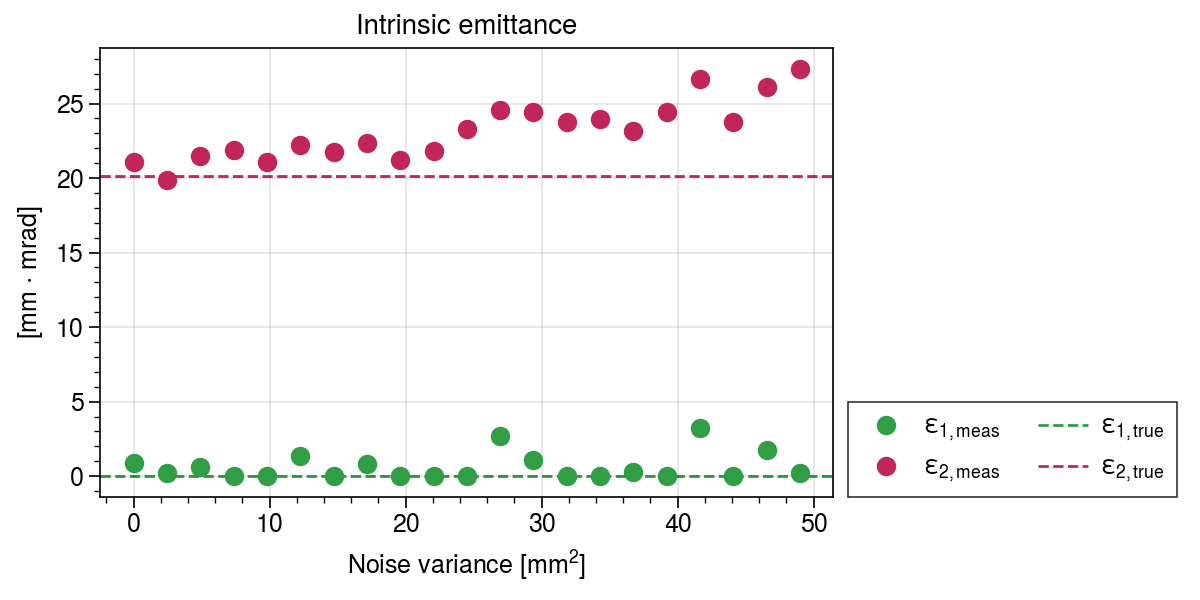

In [353]:
eps_ideal = ea.intrinsic_emittances(Sigma0)

fig, ax = plot.subplots(figsize=(6, 3))
for i, color in enumerate(['green8', 'pink8']):
    ax.plot(variances, emittances[:, i], marker='o', lw=0, color=color)
    ax.axhline(eps_ideal[i], ls='--', lw=1, zorder=0, color=color)
ax.format(grid=True, xlabel='Noise variance [mm$^2$]', ylabel='[mm $\cdot$ mrad]', title='Intrinsic emittance')
ax.legend(labels=[r'$\varepsilon_{1, meas}$', r'$\varepsilon_{1, true}$', r'$\varepsilon_{2, meas}$', r'$\varepsilon_{2, true}$'],
          ncols=2, loc=(1.02, 0));

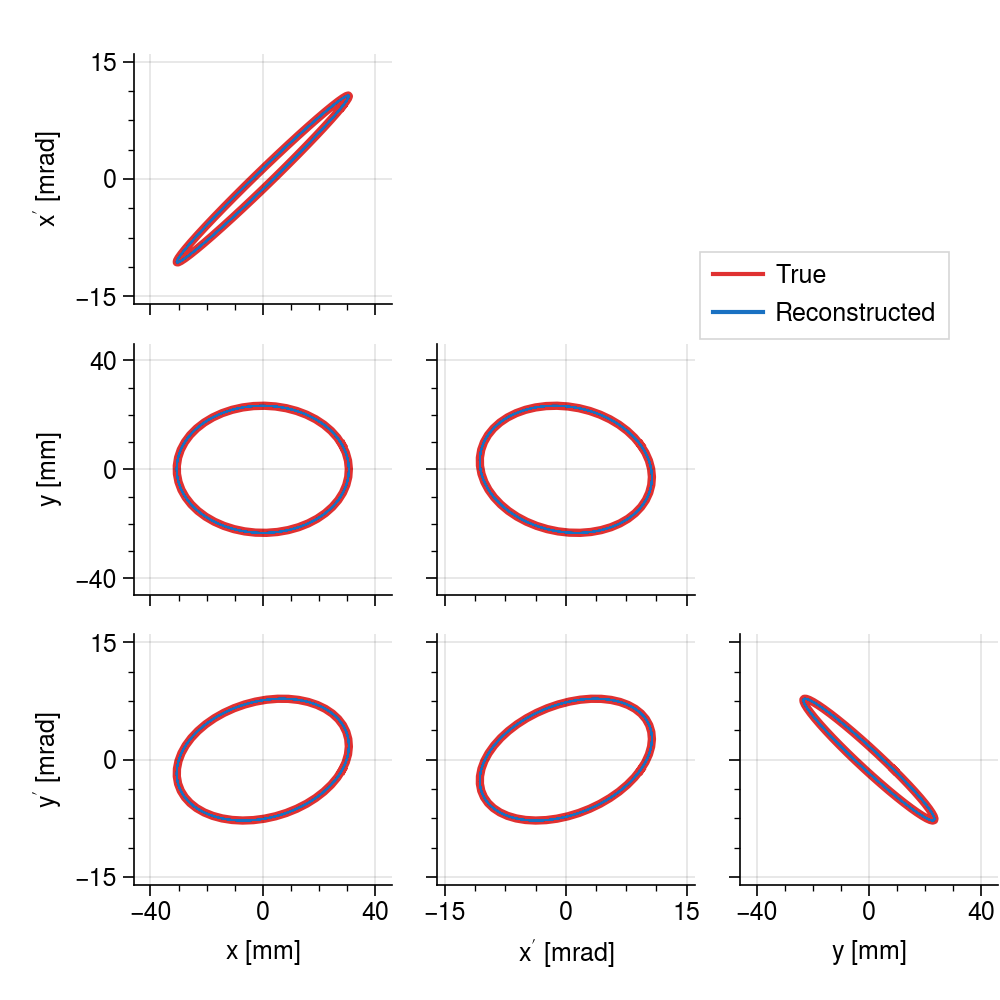

In [354]:
env_params = [fit_env(S) for S in Sigmas]
axes = myplt.corner_env(env_params, color='blue8', lw=0.57);

X = ea.get_coords(fit_env(Sigma0))
for i in range(3):
    for j in range(i + 1):
        axes[i, j].plot(X[:, j], X[:, i+1], color='red8', zorder=0, lw=3)
axes[1, 1].legend([Line2D([0], [0], color='red8'), Line2D([0], [0], color='blue8')], ['True', 'Reconstructed'], loc=(1.02, 1.02))

A variance of 50 $mm^2$ corresponds to about 7 $mm$. Assuming the beam radius is $\sqrt{4\varepsilon_x\beta_x} = \sqrt{4 (10 \times 10^{-6} m)(10 m)} = 20$ $mm$, this is a pretty significant measurement error; I am not yet sure a realistic value for this. Even so, the reconstructed emittances seem to remain close to their true values